# The goal of this note book is to explore tree generation from sample path via CDE:

In [15]:
import numpy as np
import os
import sys
import warnings
import time

# Define paths to relevant modules
measure_sampling_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Measure_sampling"
)
trees_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Trees"
)
Benchmark_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Benchmark_value_Gausian"
)
awd_trees_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/AWD_trees"
)
CD_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Conditional_density"
)
kmeans_meas_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Adapted_empirical_measure"
)
aot_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/AOT_numerics"
)

# Add paths to sys.path
for path in [
    measure_sampling_path,
    trees_path,
    Benchmark_path,
    awd_trees_path,
    CD_path,
    kmeans_meas_path,
    aot_path,
]:
    if path not in sys.path:
        sys.path.append(path)

from Build_trees_from_paths import *
from Tree_Node import *
from TreeAnalysis import *
from TreeVisualization import *
from Save_Load_trees import *
from Tree_AWD_utilities import *
from Comp_AWD2_Gaussian import build_mean_and_cov, adapted_wasserstein_squared
from Gurobi_AOT import *
from Nested_Dist_Algo import compute_nested_distance
from CD_nonparam import *

from Gen_Path_and_AdaptedTrees import *
from mainfunctions import *
from measure import *
from normal_ot import *
from FVI_bench import *

from Extract_Sample_path_AOT import extract_sample_paths

# Suppress sklearn warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from AEM_kMeans import (
    empirical_k_means_measure,
    empirical_k_means_measure_new,
    empirical_k_means_measure_grid,
)
from AEM_grid import empirical_grid_measure

## Let us first check how does it if we actually know the conditional distirbution

Follwing the non recombining tree production with path leading to 2 path done in FVI the code is on github but i also use this methode to replicate results in the notebook aot_numerics_exemple.

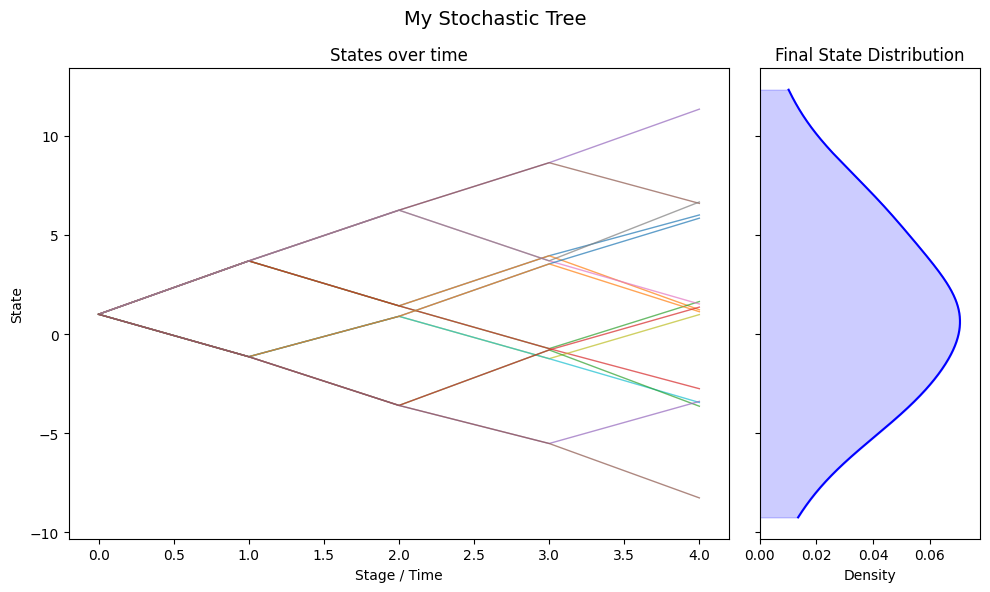

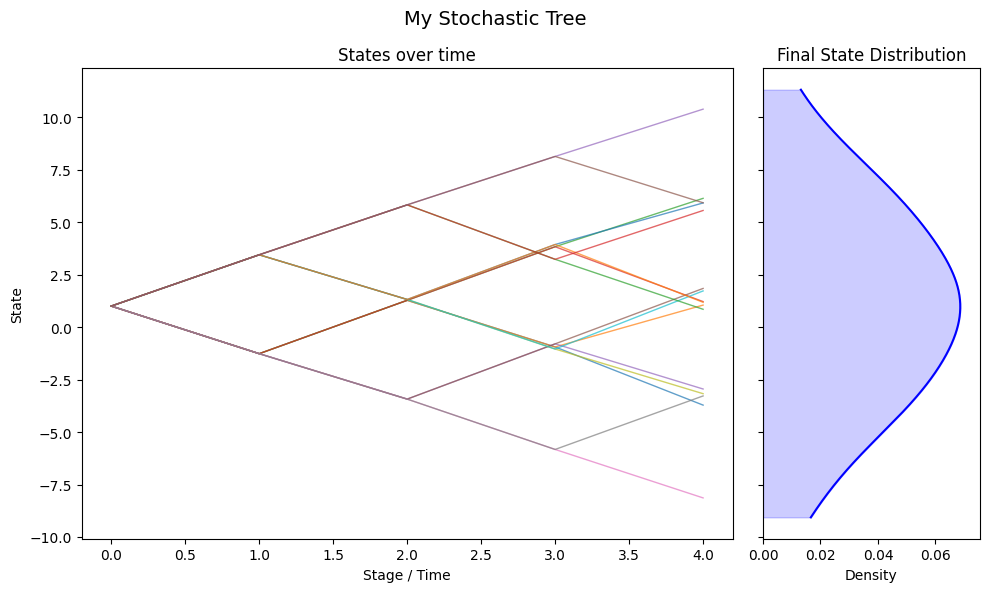

In [16]:
import numpy as np
from sklearn.cluster import KMeans


# Same mathode as in FVI code but transplated to my tree framework
def my_build_tree_binom(T, init, vol, N_leaf=2, in_size=100):
    """
    Builds a tree of depth T (i.e. T transitions, T+1 time steps) starting from init.

    At each transition, for each node in the current level, we:
      - Sample N_leaf * in_size points from N(0, vol) (as a 1D array),
      - Use KMeans clustering to obtain N_leaf cluster centers,
      - Shift these centers by the current node's value,
      - Estimate the probability of each cluster based on its relative frequency.

    The generated children are attached to the node, and the process repeats until depth T is reached.

    Parameters:
      - T (int): The number of transitions (or tree depth).
      - init (float): The initial value at the root node.
      - vol (float): The standard deviation for the Gaussian sampling.
      - N_leaf (int): The number of clusters/children per node.
      - in_size (int): The number of samples per cluster (multiplied by N_leaf) to feed into KMeans.

    Returns:
      - TreeNode: The root of the constructed tree.
    """
    # Create the root node.
    root = TreeNode(init)

    # Current level holds all nodes at the current time step.
    current_level = [root]

    # For each transition from time step t to t+1.
    for t in range(T - 1):
        next_level = []
        # For each node in the current level, generate children.
        for node in current_level:
            # Generate a bunch of random samples from a Gaussian (mean 0, std=vol).
            samples = np.random.randn(N_leaf * in_size, 1) * vol
            # Apply KMeans to get N_leaf clusters.
            kmeans = KMeans(n_clusters=N_leaf, n_init=10).fit(samples)
            # Get unique counts per cluster (to be used as probabilities).
            _, counts = np.unique(kmeans.labels_, return_counts=True)
            probs = counts / np.sum(counts)
            # Get cluster centers (they are 2D arrays, so we squeeze them).
            centers = np.squeeze(kmeans.cluster_centers_, axis=1)
            # Shift the centers by the current node's value.
            child_values = node.value + centers

            # For each child value, create a new TreeNode and add it as a child.
            for child_val, prob in zip(child_values, probs):
                child_node = TreeNode(child_val)
                node.add_child(child_node, prob)
                next_level.append(child_node)
        # Move to the next level.
        current_level = next_level

    return root


exemple_tree_1 = my_build_tree_binom(T=5, init=1, vol=3, N_leaf=2, in_size=200)

visualize_big_tree(exemple_tree_1, fig_size=(10, 6), title="My Stochastic Tree")


mu, supp_mu = rand_tree_binom(4, init=1, vol=3, N_leaf=2, in_size=200)

sample_path_x, weight_x = extract_sample_paths(mu, 4, 1)

exemple_tree_2 = build_tree_from_paths(sample_path_x, weight_x)

visualize_big_tree(exemple_tree_2, fig_size=(10, 6), title="My Stochastic Tree")

Running simulation 1/10 for n = 2, in_size = 200...
Running simulation 2/10 for n = 2, in_size = 200...
Running simulation 3/10 for n = 2, in_size = 200...
Running simulation 4/10 for n = 2, in_size = 200...
Running simulation 5/10 for n = 2, in_size = 200...
Running simulation 6/10 for n = 2, in_size = 200...
Running simulation 7/10 for n = 2, in_size = 200...
Running simulation 8/10 for n = 2, in_size = 200...
Running simulation 9/10 for n = 2, in_size = 200...
Running simulation 10/10 for n = 2, in_size = 200...


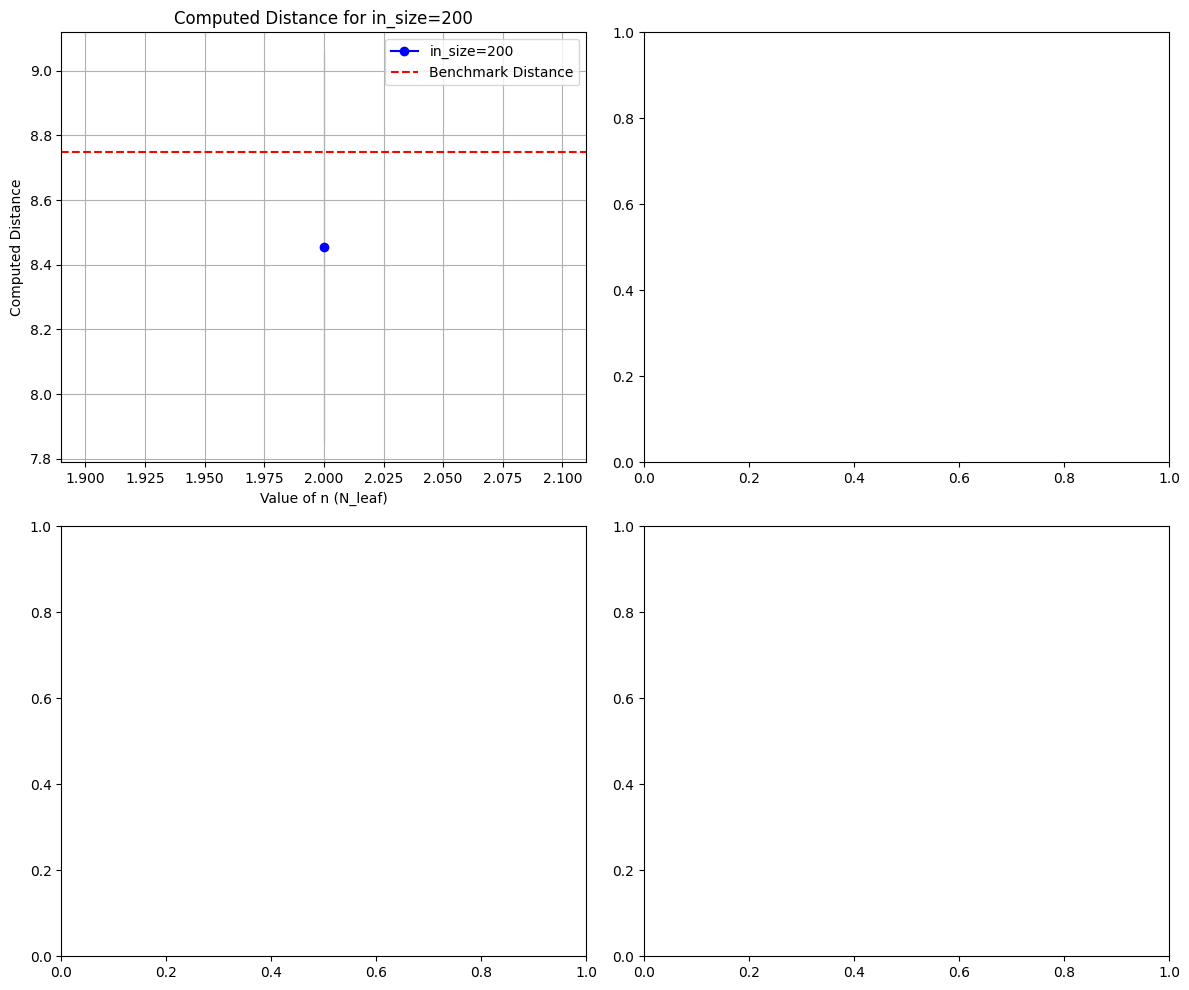

[8.45385764]
[0.60426965]


In [19]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(12345)

# Simulation parameters
n_values = range(2, 3)
in_size_values = [200]
num_runs = 10

a, b = 1, 2
vol_a, vol_b = 1, 0.5
var_a, var_b = vol_a**2, vol_b**2
t = 5
t_val = t

# Build mean and covariance matrices for both processes
a_vec, A_mat = build_mean_and_cov(t, mean_val=a, var_factor=var_a)
b_vec, B_mat = build_mean_and_cov(t, mean_val=b, var_factor=var_b)

# Compute adapted Wasserstein squared distance
benchmark_value = adapted_wasserstein_squared(a_vec, A_mat, b_vec, B_mat)

# Arrays to store results
results = {}

# Run simulations
for in_size in in_size_values:
    results[in_size] = np.zeros((len(n_values), num_runs))

    for i, n in enumerate(n_values):
        for run_idx in range(num_runs):
            print(
                f"Running simulation {run_idx+1}/{num_runs} for n = {n}, in_size = {in_size}..."
            )

            tree_root_x = my_build_tree_binom(
                T=t + 1, init=a, vol=vol_a, N_leaf=n, in_size=in_size
            )
            tree_root_y = my_build_tree_binom(
                T=t + 1, init=b, vol=vol_b, N_leaf=n, in_size=in_size
            )

            max_depth = get_depth(tree_root_x)

            distance_pot = compute_nested_distance(
                tree_root_x,
                tree_root_y,
                max_depth,
                method="solver_lp_pot",
                return_matrix=False,
                lambda_reg=0,
                power=2,
            )

            results[in_size][i, run_idx] = distance_pot - (a - b) ** 2


# Compute statistics
stats = {}
for in_size in in_size_values:
    distances_mean = results[in_size].mean(axis=1)
    distances_std = results[in_size].std(axis=1)
    stats[in_size] = (distances_mean, distances_std)

import matplotlib.pyplot as plt

# Create separate plots for each in_size
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Define colors for consistency
colors = ["blue", "green", "orange", "purple"]

for idx, (in_size, ax) in enumerate(zip(in_size_values, axes.flatten())):
    distances_mean, distances_std = stats[in_size]

    ax.plot(
        n_values,
        distances_mean,
        marker="o",
        color=colors[idx],
        label=f"in_size={in_size}",
    )
    ax.fill_between(
        n_values,
        distances_mean - distances_std,
        distances_mean + distances_std,
        alpha=0.2,
        color=colors[idx],
    )

    # Benchmark line
    ax.axhline(y=benchmark_value, color="r", linestyle="--", label="Benchmark Distance")

    ax.set_xlabel("Value of n (N_leaf)")
    ax.set_ylabel("Computed Distance")
    ax.set_title(f"Computed Distance for in_size={in_size}")
    ax.legend()
    ax.grid()

# Adjust layout
plt.tight_layout()
plt.show()

print(distances_mean)
print(distances_std)

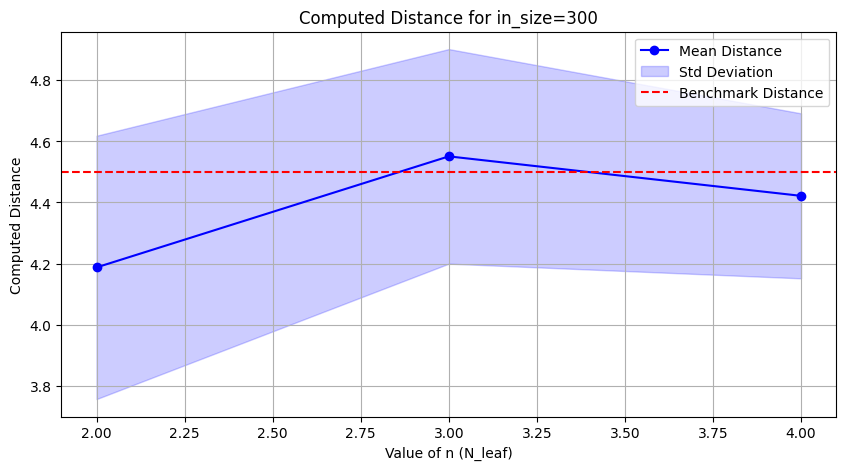

In [5]:
distances_mean, distances_std = stats[200]
plt.figure(figsize=(10, 5))
plt.plot(n_values, distances_mean, marker="o", color="blue", label="Mean Distance")
plt.fill_between(
    n_values,
    np.array(distances_mean) - np.array(distances_std),
    np.array(distances_mean) + np.array(distances_std),
    color="blue",
    alpha=0.2,
    label="Std Deviation",
)
plt.axhline(y=benchmark_value, color="red", linestyle="--", label="Benchmark Distance")
plt.xlabel("Value of n (N_leaf)")
plt.ylabel("Computed Distance")
plt.title(f"Computed Distance for in_size={300}")
plt.legend()
plt.grid()
plt.show()

## Checking douvble convergence with tree gen an then using clustering algo (help does not change or worsten)



## Please note the the bellow likely does not work as be do no have iid sample path

[3.57068895e-03 3.27390441e-03 4.20135608e-03 1.57666785e-03
 1.28915783e-03 5.35700889e-03 4.14585906e-03 4.25067010e-03
 1.86330744e-03 1.85166177e-03 5.97690078e-03 2.39927846e-03
 2.58383834e-03 5.52259954e-03 4.81275384e-03 2.53173297e-03
 2.11152833e-03 1.71233392e-03 6.56569753e-04 8.66672074e-04
 8.32755557e-04 1.67016338e-03 6.69926258e-04 1.74459963e-03
 2.06095370e-03 4.38752870e-03 4.39932314e-03 2.44144742e-03
 4.72956723e-03 1.73378150e-03 4.95080524e-03 1.69204736e-03
 4.51212629e-03 1.74218210e-03 5.90336523e-03 3.11786314e-03
 2.48479448e-03 6.99540867e-03 6.36234001e-03 4.77966837e-03
 2.23186944e-03 1.90525440e-03 2.35707187e-03 1.01795021e-03
 6.53230080e-04 2.16711767e-03 8.26483902e-04 5.71811537e-04
 2.09023545e-03 1.55205989e-03 1.56972108e-03 3.25836043e-03
 3.32971138e-03 1.01476918e-03 2.71926430e-03 9.84992933e-04
 8.00733285e-04 3.73068917e-04 8.57603547e-04 3.95817022e-04
 9.46015584e-04 2.43805358e-03 2.11424959e-03 1.41584883e-03
 2.60947923e-03 1.238311

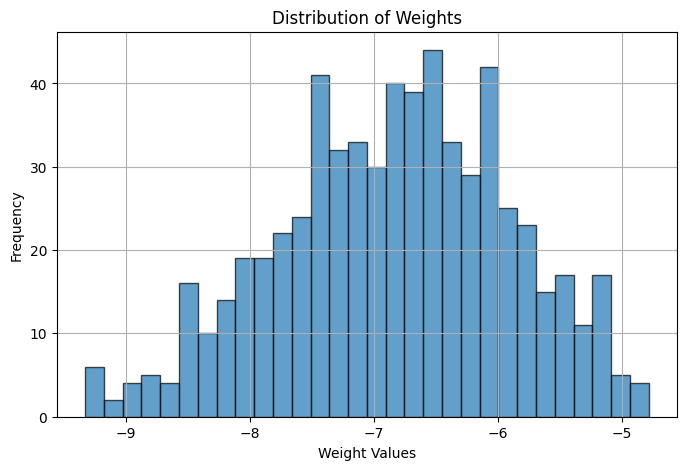

In [6]:
tree_root_exemple = my_build_tree_binom(T=4 + 1, init=1, vol=1, N_leaf=5, in_size=300)
formatted_tree_1 = get_sample_paths(tree_root_exemple)
print(formatted_tree_1[1])

import numpy as np
import matplotlib.pyplot as plt

# Assuming `formatted_tree_1[1]` contains the weights
weights = formatted_tree_1[1]  # Replace this with the actual list of weights

# Convert to numpy array for numerical operations
weights = np.array(weights)

# Compute statistics
num_weights = weights
mean_weight = np.mean(weights)
std_weight = np.std(weights)

# Print statistics
print(f"Number of weights: {num_weights}")
print(f"Mean weight: {mean_weight:.4f}")
print(f"Standard deviation of weights: {std_weight:.4f}")

# Plot the distribution
plt.figure(figsize=(8, 5))
plt.hist(np.log(weights), bins=30, alpha=0.7, edgecolor="black")
plt.xlabel("Weight Values")
plt.ylabel("Frequency")
plt.title("Distribution of Weights")
plt.grid(True)
plt.show()

Running simulation 1/10 for n = 2
Running simulation 2/10 for n = 2
Running simulation 3/10 for n = 2
Running simulation 4/10 for n = 2
Running simulation 5/10 for n = 2
Running simulation 6/10 for n = 2
Running simulation 7/10 for n = 2
Running simulation 8/10 for n = 2
Running simulation 9/10 for n = 2
Running simulation 10/10 for n = 2
Running simulation 1/10 for n = 3
Running simulation 2/10 for n = 3
Running simulation 3/10 for n = 3
Running simulation 4/10 for n = 3
Running simulation 5/10 for n = 3
Running simulation 6/10 for n = 3
Running simulation 7/10 for n = 3
Running simulation 8/10 for n = 3
Running simulation 9/10 for n = 3
Running simulation 10/10 for n = 3
Running simulation 1/10 for n = 4
Running simulation 2/10 for n = 4
Running simulation 3/10 for n = 4
Running simulation 4/10 for n = 4
Running simulation 5/10 for n = 4
Running simulation 6/10 for n = 4
Running simulation 7/10 for n = 4
Running simulation 8/10 for n = 4
Running simulation 9/10 for n = 4
Running simu

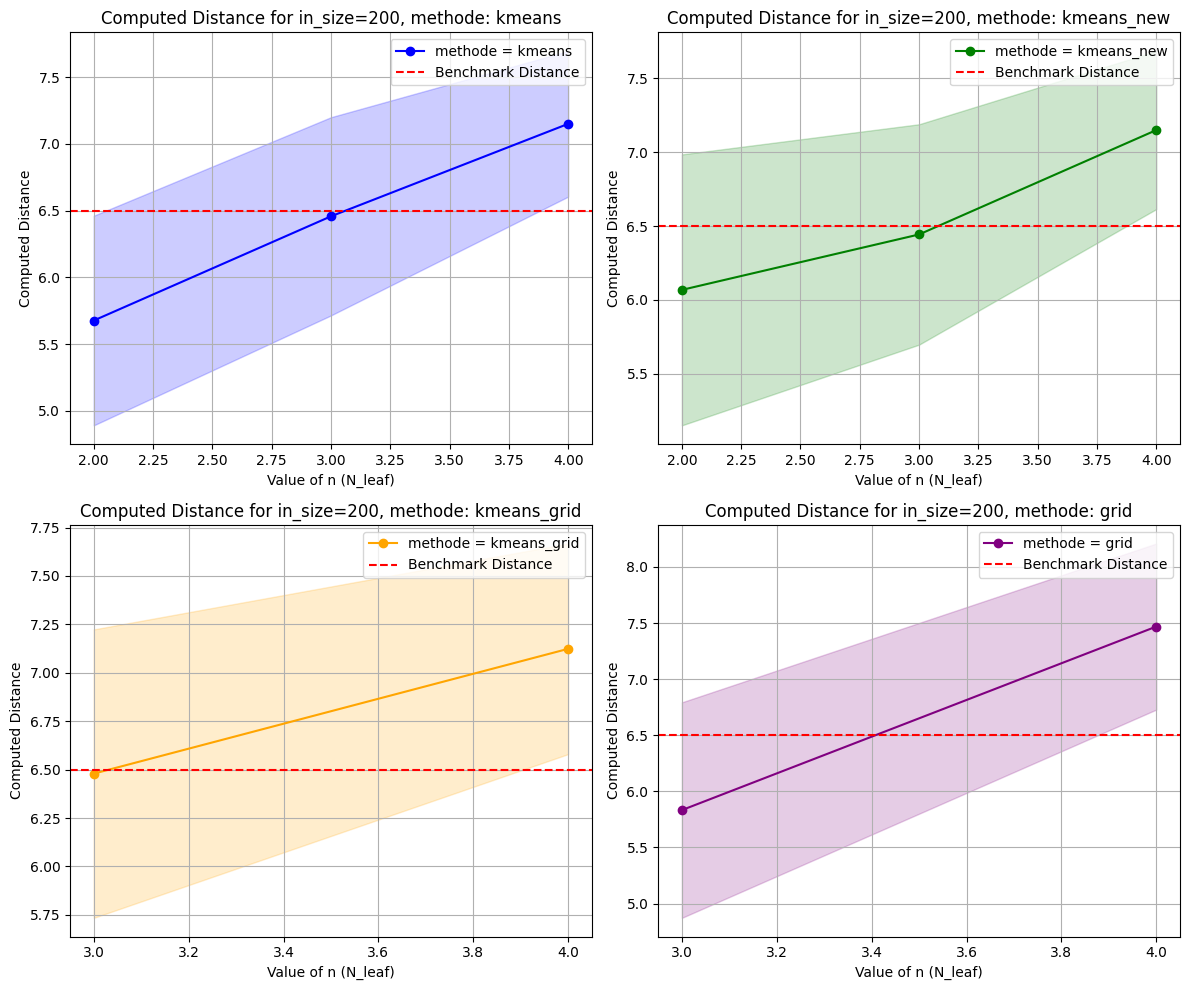

In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(12345)

# Simulation parameters
max_iter = 5
n_values = list(range(2, max_iter))  # n from 2 to max_iter-1
in_size = 200
num_runs = 10

methodes = ["kmeans", "kmeans_new", "kmeans_grid", "grid"]

a, b = 1, 2
vol_a, vol_b = 1, 0.5
var_a, var_b = vol_a**2, vol_b**2
t = 4
t_val = t

# Build mean and covariance matrices for both processes
a_vec, A_mat = build_mean_and_cov(t, mean_val=a, var_factor=var_a)
b_vec, B_mat = build_mean_and_cov(t, mean_val=b, var_factor=var_b)

# Compute adapted Wasserstein squared distance benchmark
benchmark_value = adapted_wasserstein_squared(a_vec, A_mat, b_vec, B_mat)

# Initialize results dictionary for all methods
results = {methode: np.zeros((len(n_values), num_runs)) for methode in methodes}

# Run simulations: Loop over n and then over runs and methods
for i, n in enumerate(n_values):
    for run_idx in range(num_runs):
        print(f"Running simulation {run_idx+1}/{num_runs} for n = {n}")

        # Build the initial trees and obtain sample paths (common for all methods)
        tree_root_x = my_build_tree_binom(
            T=t + 1, init=a, vol=vol_a, N_leaf=n, in_size=in_size
        )
        tree_root_y = my_build_tree_binom(
            T=t + 1, init=b, vol=vol_b, N_leaf=n, in_size=in_size
        )
        formatted_tree_x = get_sample_paths(tree_root_x)
        formatted_tree_y = get_sample_paths(tree_root_y)
        sample_paths_x = formatted_tree_x[0]
        sample_paths_y = formatted_tree_y[0]
        use_weights = True

        # Compute for each method in the same loop
        for methode in methodes:
            # For 'kmeans_grid' and 'grid', only run if n>=3
            if methode in ["kmeans_grid", "grid"] and n < 3:
                continue

            # Compute the empirical measure based on the chosen method
            if methode == "kmeans":
                new_sample_paths_x, new_weights_x = empirical_k_means_measure(
                    sample_paths_x, use_weights=use_weights
                )
                new_sample_paths_y, new_weights_y = empirical_k_means_measure(
                    sample_paths_y, use_weights=use_weights
                )
            elif methode == "kmeans_new":
                new_sample_paths_x, new_weights_x = empirical_k_means_measure_new(
                    sample_paths_x, use_weights=use_weights
                )
                new_sample_paths_y, new_weights_y = empirical_k_means_measure_new(
                    sample_paths_y, use_weights=use_weights
                )
            elif methode == "kmeans_grid":
                new_sample_paths_x, new_weights_x = empirical_k_means_measure_grid(
                    sample_paths_x, use_weights=use_weights
                )
                new_sample_paths_y, new_weights_y = empirical_k_means_measure_grid(
                    sample_paths_y, use_weights=use_weights
                )
            elif methode == "grid":
                N = int(np.round(np.sqrt(n**t)))
                new_sample_paths_x, new_weights_x = empirical_grid_measure(
                    sample_paths_x, N=N, use_weights=use_weights
                )
                new_sample_paths_y, new_weights_y = empirical_grid_measure(
                    sample_paths_y, N=N, use_weights=use_weights
                )

            # Rebuild trees from the new empirical measures
            tree_root_x_new = build_tree_from_paths(new_sample_paths_x, new_weights_x)
            tree_root_y_new = build_tree_from_paths(new_sample_paths_y, new_weights_y)
            max_depth = get_depth(tree_root_x_new)

            # Compute the nested (adapted Wasserstein) distance
            distance_pot = compute_nested_distance(
                tree_root_x_new,
                tree_root_y_new,
                max_depth,
                method="solver_lp_pot",
                return_matrix=False,
                lambda_reg=0,
                power=2,
            )
            # Store the adjusted result (subtracting (a-b)^2)
            results[methode][i, run_idx] = distance_pot - (a - b) ** 2

# Compute statistics for each method
stats = {}
# For methods computed for n from 2 onwards:
for methode in ["kmeans", "kmeans_new"]:
    distances_mean = results[methode].mean(axis=1)
    distances_std = results[methode].std(axis=1)
    stats[methode] = (distances_mean, distances_std)

# For methods computed only for n>=3 (kmeans_grid and grid)
# Identify indices corresponding to n >= 3 in n_values (n_values is a list)
n_values_grid = [n for n in n_values if n >= 3]
stats_grid = {}
for methode in ["kmeans_grid", "grid"]:
    # Filter out the rows corresponding to n>=3
    idx = [i for i, n in enumerate(n_values) if n >= 3]
    distances_mean = results[methode][idx, :].mean(axis=1)
    distances_std = results[methode][idx, :].std(axis=1)
    stats_grid[methode] = (distances_mean, distances_std)

# %% Plotting

# Create separate plots for each method
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# Define colors for consistency
colors = {
    "kmeans": "blue",
    "kmeans_new": "green",
    "kmeans_grid": "orange",
    "grid": "purple",
}

for idx, (methode, ax) in enumerate(zip(methodes, axes.flatten())):
    if methode in ["kmeans_grid", "grid"]:
        distances_mean, distances_std = stats_grid[methode]
        ax.plot(
            n_values_grid,
            distances_mean,
            marker="o",
            color=colors[methode],
            label=f"methode = {methode}",
        )
        ax.fill_between(
            n_values_grid,
            distances_mean - distances_std,
            distances_mean + distances_std,
            alpha=0.2,
            color=colors[methode],
        )
    else:
        distances_mean, distances_std = stats[methode]
        ax.plot(
            n_values,
            distances_mean,
            marker="o",
            color=colors[methode],
            label=f"methode = {methode}",
        )
        ax.fill_between(
            n_values,
            distances_mean - distances_std,
            distances_mean + distances_std,
            alpha=0.2,
            color=colors[methode],
        )

    # Benchmark line
    ax.axhline(y=benchmark_value, color="r", linestyle="--", label="Benchmark Distance")
    ax.set_xlabel("Value of n (N_leaf)")
    ax.set_ylabel("Computed Distance")
    ax.set_title(f"Computed Distance for in_size={in_size}, methode: {methode}")
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

## Bellow: some code I keep but but not updated yet

In [ ]:
# Generate sample paths
paths_x = generate_brownian_motion(num_paths=3000, time_steps=4, x_init=1, scale=1)
print("Shape of generated paths:", paths_x.shape)

# Generate sample paths
paths_y = generate_brownian_motion(num_paths=3000, time_steps=4, x_init=2, scale=0.5)
print("Shape of generated paths:", paths_y.shape)

In [ ]:
def discretize_density_random(y_grid, density, n_points):
    """
    Discretizes a continuous density into n_points by randomly sampling according to the density.

    This function normalizes the density, computes the cumulative distribution function (CDF),
    and then uses inverse transform sampling to obtain discrete points.

    Args:
        y_grid (np.ndarray): 1D grid on which the density is evaluated.
        density (np.ndarray): Estimated density values on the y_grid.
        n_points (int): Number of discrete points to sample.

    Returns:
        discrete_points (np.ndarray): The randomly sampled points from the density.
    """
    # Normalize the density using numerical integration
    density = density / np.trapz(density, y_grid)

    # Compute the cumulative distribution function (CDF)
    cdf = np.cumsum(density) * (y_grid[1] - y_grid[0])
    cdf = cdf / cdf[-1]

    # Draw n_points random samples from a uniform distribution over [0,1]
    random_quantiles = np.sort(np.random.rand(n_points))

    # Inverse transform sampling: interpolate y_grid values corresponding to these quantiles
    discrete_points = np.interp(random_quantiles, cdf, y_grid)
    return discrete_points


# Now we build the tree using the conditional density estimates:
def build_discrete_tree_framework(
    paths, n_points=2, bandwidth_joint=0.5, bandwidth_marginal=0.5
):
    """
    Constructs a discrete tree (using the TreeNode framework) by estimating conditional densities
    and discretizing them into n_points equally likely children at each time step.

    Args:
        paths (np.ndarray): Array of shape (num_paths, time_steps) from Brownian motion.
        n_points (int): Number of discrete points per transition (default 2).
        bandwidth_joint (float): Bandwidth for joint density estimation.
        bandwidth_marginal (float): Bandwidth for marginal density estimation.

    Returns:
        TreeNode: The root of the constructed tree.
    """
    num_time_steps = paths.shape[1]
    # Create the root node (assumes all paths share the same initial value)
    root = TreeNode(paths[0, 0])

    # Start with the root node, carrying probability 1.
    current_level = [(root, 1.0)]

    # Loop over transitions: from time step t to t+1
    for t in range(num_time_steps - 1):
        # Extract the data for this transition.
        X = paths[:, t].reshape(-1, 1)
        Y = paths[:, t + 1].reshape(-1, 1)
        data = np.hstack([X, Y])

        # Define a grid for the y-values based on the data at time t+1.
        y_min = np.min(Y) - 3
        y_max = np.max(Y) + 3
        y_grid = np.linspace(y_min, y_max, 200)

        next_level = []
        for node, parent_prob in current_level:
            # Estimate the conditional density for the parent's value.
            f_cond = estimate_conditional_density_one_step(
                data, node.value, bandwidth_joint, bandwidth_marginal, y_grid
            )
            # Discretize the density into n_points (equally likely branches).
            discrete_points = discretize_density_random(y_grid, f_cond, n_points)

            # Each branch gets equal conditional probability.
            branch_prob = 1.0 / n_points
            for dp in discrete_points:
                child_node = TreeNode(dp)
                node.add_child(child_node, branch_prob)
                next_level.append((child_node, parent_prob * branch_prob))
        current_level = next_level

    return root

In [ ]:
# Build the tree from these paths.
root_node_x = build_discrete_tree_framework(paths_x, n_points=3)
root_node_y = build_discrete_tree_framework(paths_y, n_points=3)

visualize_tree(root_node_x, title="Adapted Tree")
visualize_tree(root_node_y, title="Adapted Tree")


# Only generation three like that is not good as they only expand you mant them to merge after so use:
formatted_tree_x = get_sample_paths(root_node_x)
formatted_tree_y = get_sample_paths(root_node_y)

new_sample_paths_x, new_weights_x = empirical_k_means_measure(
    formatted_tree_x[0], use_weights=True
)
new_sample_paths_y, new_weights_y = empirical_k_means_measure(
    formatted_tree_y[0], use_weights=True
)

tree_root_x = build_tree_from_paths(new_sample_paths_x, new_weights_x)
tree_root_y = build_tree_from_paths(new_sample_paths_y, new_weights_y)

visualize_tree(tree_root_x, title="Adapted Tree")
visualize_tree(tree_root_y, title="Adapted Tree")

formatted_tree_x = get_sample_paths(tree_root_x)
formatted_tree_y = get_sample_paths(tree_root_y)

display_tree_data(formatted_tree_x, "Tree x")
display_tree_data(formatted_tree_y, "Tree y")

In [ ]:
import random
import numpy as np

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Simulation parameters
n_values = range(1, 2)
num_runs = 10
benchmark_value = 4.5

# Arrays to store results
distances_all = np.zeros((len(n_values), num_runs))

# Run simulations
for i, n in enumerate(n_values):
    for run_idx in range(num_runs):
        print(f"Running simulation {run_idx+1}/{num_runs} for n = {n}...")
        # Generate sample paths
        paths_x = generate_brownian_motion(
            num_paths=3000, time_steps=4, x_init=1, scale=1
        )
        paths_y = generate_brownian_motion(
            num_paths=3000, time_steps=4, x_init=2, scale=0.5
        )

        # Build trees
        root_node_x = build_discrete_tree_framework(paths_x, n_points=n)
        root_node_y = build_discrete_tree_framework(paths_y, n_points=n)

        # Only generation three like that is not good as they only expand you mant them to merge after so use:
        formatted_tree_x = get_sample_paths(root_node_x)
        formatted_tree_y = get_sample_paths(root_node_y)

        new_sample_paths_x, new_weights_x = empirical_grid_measure(
            formatted_tree_x[0], use_weights=True
        )
        new_sample_paths_y, new_weights_y = empirical_grid_measure(
            formatted_tree_y[0], use_weights=True
        )

        tree_root_x = build_tree_from_paths(new_sample_paths_x, new_weights_x)
        tree_root_y = build_tree_from_paths(new_sample_paths_y, new_weights_y)

        max_depth = get_depth(root_node_x)

        # Compute nested distance
        distance = compute_nested_distance(
            tree_root_x,
            tree_root_y,
            max_depth,
            method="solver_lp_pot",
            return_matrix=False,
            lambda_reg=0,
        )

        distances_all[i, run_idx] = distance - 1

# Compute statistics
distances_mean = distances_all.mean(axis=1)
distances_std = distances_all.std(axis=1)

# Plot results
plt.figure(figsize=(10, 5))

# Mean distance
plt.plot(n_values, distances_mean, label="Mean Distance", marker="o", color="blue")

# Fill between mean ± std
plt.fill_between(
    n_values,
    distances_mean - distances_std,
    distances_mean + distances_std,
    alpha=0.2,
    color="blue",
    label="Std Deviation",
)

# Benchmark line
plt.axhline(y=benchmark_value, color="r", linestyle="--", label="Benchmark Distance")

plt.xlabel("Value of n")
plt.ylabel("Computed Distance")
plt.title("Computed Distance vs Benchmark (Mean ± Std)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)


def generate_recursive_paths(x_init, time_steps, scale, n_points):
    """
    Generate complete sample paths recursively.

    Each path is a sequence of values where:
      - The first value is x_init.
      - At each subsequent time step, n_points samples are generated from a Gaussian
        centered at the value from the previous step with standard deviation 'scale'.

    For time_steps t, the function returns a 2D NumPy array of shape
      (n_points^(t-1), t)
    where each row is a sample path.

    Parameters:
        x_init (float): The starting value.
        time_steps (int): Total number of time steps (including the initial step).
        scale (float): The standard deviation for the Gaussian sampling.
        n_points (int): Number of samples to generate at each branching.

    Returns:
        np.ndarray: A 2D array where each row represents a complete sample path.
    """

    def rec_path(current_value, remaining_steps):
        # Base case: if no more steps, return a path containing only the current value.
        if remaining_steps == 0:
            return [[current_value]]
        else:
            paths = []
            # Generate n_points samples from Gaussian centered at current_value.
            samples = np.random.normal(loc=current_value, scale=scale, size=n_points)
            for s in samples:
                # Recursively generate paths starting from sample s.
                for tail in rec_path(s, remaining_steps - 1):
                    paths.append([current_value] + tail)
            return paths

    # We need to take time_steps-1 recursive steps because the first step is x_init.
    all_paths = rec_path(x_init, time_steps - 1)
    return np.array(all_paths)


# Simulation parameters
n_values = range(5, 13)
num_runs = 10
benchmark_value = 4.5

# Arrays to store results
distances_all = np.zeros((len(n_values), num_runs))

# Run simulations
for i, n in enumerate(n_values):
    for run_idx in range(num_runs):
        print(f"Running simulation {run_idx+1}/{num_runs} for n = {n}...")

        # Generate sample paths using the new recursive function:
        # For x_path: initial value 1, for y_path: initial value 2.
        x_path = generate_recursive_paths(x_init=1, time_steps=4, scale=1, n_points=n)
        y_path = generate_recursive_paths(x_init=2, time_steps=4, scale=0.5, n_points=n)

        new_sample_paths_x, new_weights_x = empirical_k_means_measure_grid(
            x_path, use_weights=True
        )
        new_sample_paths_y, new_weights_y = empirical_k_means_measure_grid(
            y_path, use_weights=True
        )

        tree_root_x = build_tree_from_paths(new_sample_paths_x, new_weights_x)
        tree_root_y = build_tree_from_paths(new_sample_paths_y, new_weights_y)

        max_depth = get_depth(tree_root_x)

        # Compute nested distance
        distance = compute_nested_distance(
            tree_root_x,
            tree_root_y,
            max_depth,
            method="solver_lp_pot",
            return_matrix=False,
            lambda_reg=0,
        )

        distances_all[i, run_idx] = distance - 1

# Compute statistics
distances_mean = distances_all.mean(axis=1)
distances_std = distances_all.std(axis=1)

# Plot results
plt.figure(figsize=(10, 5))

# Mean distance
plt.plot(n_values, distances_mean, label="Mean Distance", marker="o", color="blue")

# Fill between mean ± std
plt.fill_between(
    n_values,
    distances_mean - distances_std,
    distances_mean + distances_std,
    alpha=0.2,
    color="blue",
    label="Std Deviation",
)

# Benchmark line
plt.axhline(y=benchmark_value, color="r", linestyle="--", label="Benchmark Distance")

plt.xlabel("Value of n")
plt.ylabel("Computed Distance")
plt.title("Computed Distance vs Benchmark (Mean ± Std)")
plt.legend()
plt.grid()
plt.show()